<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Object_Localization_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras as keras

import cv2
from google.colab.patches import cv2_imshow

from matplotlib.patches import Rectangle
from tensorflow.keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
from glob import glob

# Side note: try doing all the image operations using openCV after practice

In [ ]:
# although our image is gray_scale images, we use an abitrary color channel of 3 rather than 1
# since that's what's expected by VGG
vgg = keras.applications.VGG16(
    input_shape = [100, 100, 3], include_top = False
)

**Build the Model**

In [ ]:
x = keras.layers.Flatten()(vgg.output)
x = keras.layers.Dense(4, activation = "sigmoid")(x)
model = keras.models.Model(inputs = vgg.input, outputs = x)

**Build Generator to generate our own dataset**

In [3]:
# helper to generate image and target(y, x,  h, w)

def image_generator(batch_size = 64):
  while True:

    # each epoch will have 50 batches
    for _ in range(50):
      x = np.zeros((batch_size, 100, 100, 3))  # all black X image, since pixel of 0 = black
      y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # make boxes and store their location in target
        row0 = np.random.randint(90)
        col0 = np.random.randint(90)
        row1 = np.random.randint(row0, 100)
        col1 = np.random.randint(col0, 100)
        x[i, row0:row1, col0:col1, :] = 1  # makes this location to be white, i.e drawing the white box

        # normalize y, x, h and w of y to be in range 0 and 1
        y[i, 0] = row0/ 100
        y[i, 1] = row0/ 100
        y[i, 2] = (row1  - row0) / 100
        y[i, 3] = (col1  - col0) / 100

      # yields a batch
      yield x, y


In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate=0.001))

**Train and Viz Results**

In [ ]:
model.fit(
    image_generator(),
    steps_per_epoch = 50,  # batch_size
    epochs = 5
)

Epoch 1/5
50/50 [==============================] - 14s 180ms/step - loss: 0.6533
Epoch 2/5
50/50 [==============================] - 9s 182ms/step - loss: 0.5209
Epoch 3/5
50/50 [==============================] - 9s 182ms/step - loss: 0.5086
Epoch 4/5
50/50 [==============================] - 9s 180ms/step - loss: 0.5074
Epoch 5/5
50/50 [==============================] - 9s 177ms/step - loss: 0.5074


In [4]:
# helper for making predictions and drawing the bouding boxes
def visualize_predictions():
  # generate a random image and draw white box on top
  x  = np.zeros((100, 100, 3))
  row0 = np.random.randint(90)
  col0 = np.random.randint(90)
  row1 = np.random.randint(row0, 100)
  col1 = np.random.randint(col0, 100)
  x[row0:row1,col0:col1,:] = 1
  print(row0, col0, row1, col1)

  X = x[np.newaxis, ...]
  p = model.predict(X)[0]

  # todo: try this shit later using opencv to plot
  
  # draw box in matplotlib
  fig, ax = plt.subplots(1)
  ax.imshow(x)
  rect = Rectangle(
      (p[1]*100, p[0]*100),
      p[3]*100, p[2]*100,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()




36 35 96 55
1/1 [==============================] - 0s 19ms/step


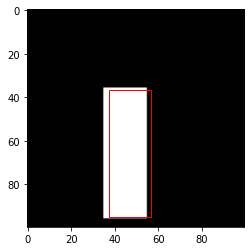

In [ ]:
visualize_predictions()

### **Object Localization of Pokemon charmander**

In [1]:
# get the charmander image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2023-02-12 14:58:51--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-02-12 14:58:51 (52.2 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



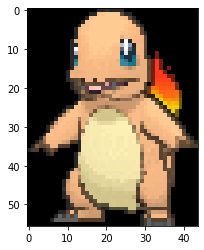

In [5]:
ch = image.load_img("charmander-tight.png")
plt.imshow(ch);

In [6]:
# cast to PIL to np array and get shape
np.array(ch).shape

(56, 44, 3)

image type is : <class 'imageio.core.util.Array'>
(56, 44, 4)


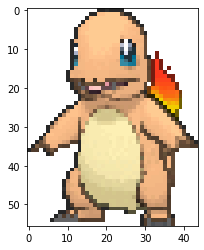

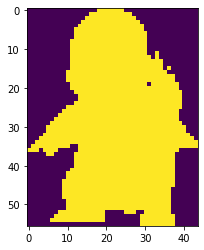

In [7]:
# alt way of loading image, but using this color channel is 4
# with the added dim for alpha (for png images)
ch = imread("charmander-tight.png")

plt.imshow(ch)

print(f"image type is : {type(ch)}")

print(ch.shape)

# what's in the 4th channel?
plt.figure()
plt.imshow(ch[:,:,3]);

**Setup generator and train model**

In [8]:
POKE_DIM = 200 # full image dim
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape



def pokemon_generator(batch_size = 64):
  """
  helper to build our image generator
  """

  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))
      
      for i in range(batch_size):
        # choose location and store in target
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_W)
        row1 = row0 + CH_H
        col1 = col0 + CH_W
        # draws the charmander on the image
        # and since charmander has 4 channels, exclude the alpha channel
        X[i,row0:row1,col0:col1,:] = ch[:,:,:3]  
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM
        
        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM
      
      yield X / 255., Y  # scale x and yield



def make_model():
  """
  helper to build our object localization model
  n.b: meant to freeze VGG layers before training
  """
  vgg = keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  
  for layer in vgg.layers:
    layer.trainable = False

  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)

  model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = 0.001))
  return model

In [13]:
model = make_model()

model.fit(
    pokemon_generator(),
    steps_per_epoch = 50,
    epochs = 5
)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/5
50/50 [==============================] - 55s 625ms/step - loss: 0.9146
Epoch 2/5
50/50 [==============================] - 32s 647ms/step - loss: 0.5554
Epoch 3/5
50/50 [==============================] - 32s 649ms/step - loss: 0.5545
Epoch 4/5
50/50 [==============================] - 32s 642ms/step - loss: 0.5541
Epoch 5/5
50/50 [==============================] - 32s 643ms/step - loss: 0.5552


In [9]:
def pokemon_prediction():
  """
  helper to make predictions
  """
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W
  x[row0:row1,col0:col1,:] = ch[:,:,:3]
  print("true:", row0, col0, row1, col1)

  X = x[np.newaxis, ...] / 255.
  p = model.predict(X)[0]

  # calc the target / loss manually
  y = np.zeros(4)
  y[0] = row0/POKE_DIM
  y[1] = col0/POKE_DIM
  y[2] = (row1 - row0)/POKE_DIM
  y[3] = (col1 - col0)/POKE_DIM

  # prints cord of predicted box in cartesin cord and loss
  row0 = int(p[0] * POKE_DIM)
  col0 = int(p[1] *POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)  # since p[2] is pred box height, add to row0 to get row1
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred: ", row0, col0, row1, col1)
  print(f"log_loss: {-np.mean(y * np.log(p) + (1 - y) * np.log(1 -p)):.2f}" )


  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 85 129 141 173
1/1 [==============================] - 1s 728ms/step
pred:  84 128 140 171
log_loss: 0.61


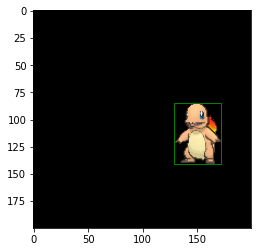

In [15]:
pokemon_prediction()

### **Object Localization of Resized Pokemon charmander**

In [10]:
def pokemon_generator_with_resize(batch_size = 64):
  """
  helper to build our image generator
  """

  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))
      
      for i in range(batch_size):
        # resize charmander - randomly making it bigger or smaller
        scale = 0.5 + np.random.random()  # [0.5, 1.5] i.e adding 0.5 to [0.0 - 1.0]
        new_h = int(CH_H * scale)
        new_w = int(CH_W * scale)
        obj = resize(
            ch, (new_h, new_w),
            preserve_range = True
        ).astype(np.uint8)  # keep it from 0..255


        # choose location and store in target
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_W)
        row1 = row0 + CH_H
        col1 = col0 + CH_W
        # draws the charmander on the image
        # and since charmander has 4 channels, exclude the alpha channel
        X[i,row0:row1,col0:col1,:] = ch[:,:,:3]  
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM
        
        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM
      
      yield X / 255., Y  # scale x and yield

In [21]:
def make_model2():
  # make the model with edited learning_rate
  vgg = keras.applications.VGG16(
      input_shape = [POKE_DIM, POKE_DIM, 3],
      include_top = False,
      weights = "imagenet"
  )

  for layer in vgg.layers:
    layer.trainable = False


  x = Flatten()(vgg.output)
  x = Dense(4, activation ="sigmoid")(x)
  model = Model(inputs = vgg.input, outputs = x)
  model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = 0.0001))
  return model

In [58]:
model = make_model2()
model.fit(
    pokemon_generator_with_resize(),
    steps_per_epoch = 50,
    epochs = 5
)

Epoch 1/5
50/50 [==============================] - 38s 683ms/step - loss: 0.5606
Epoch 2/5
50/50 [==============================] - 34s 683ms/step - loss: 0.5542
Epoch 3/5
50/50 [==============================] - 34s 673ms/step - loss: 0.5506
Epoch 4/5
50/50 [==============================] - 34s 679ms/step - loss: 0.5524
Epoch 5/5
50/50 [==============================] - 34s 678ms/step - loss: 0.5530


In [12]:
# Make predictions with resize
def pokemon_prediction_with_resize():
  # resize charmander - make it bigger or smaller
  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8) # keep it from 0..255
  
  # Generate a random image
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - new_height)
  col0 = np.random.randint(POKE_DIM - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width
  x[row0:row1,col0:col1,:] = obj[:,:,:3]
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 115 11 166 51
1/1 [==============================] - 0s 28ms/step
pred: 108 12 162 56


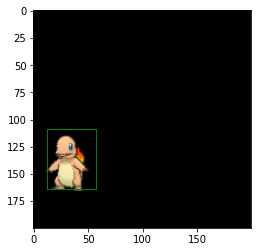

In [72]:
pokemon_prediction_with_resize()

### **Object Localization of horizontally flipped Pokemon charmander** 

In [13]:
# side_note: try chaning lighting of charmander to see if model will still work properly

def pokemon_generator_filp(batch_size = 64):

  while True:
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_W)
        row1 = row0 + CH_H
        col1 = col0 + CH_W

        # flip image left to right 50 % of the time
        if (np.random.random() < 0.5):
          obj = np.fliplr(ch)
        else:
          obj = ch

        X[i, row0:row1, col0:col1, :] = obj[:,:,:3]
        Y[i, 0] = row0 / POKE_DIM
        Y[i, 1] = col0 / POKE_DIM

        Y[i, 2] = (row1 - row0) / POKE_DIM
        Y[i, 3] = (col1 - col0) / POKE_DIM

      yield X / 255., Y        

In [18]:
model = make_model()

model.fit(
    pokemon_generator_filp(),
    steps_per_epoch = 50,
    epochs = 5
)

Epoch 1/5
50/50 [==============================] - 11s 201ms/step - loss: 0.5860
Epoch 2/5
50/50 [==============================] - 10s 205ms/step - loss: 0.5538
Epoch 3/5
50/50 [==============================] - 10s 208ms/step - loss: 0.5545
Epoch 4/5
50/50 [==============================] - 10s 206ms/step - loss: 0.5558
Epoch 5/5
50/50 [==============================] - 10s 203ms/step - loss: 0.5529


In [14]:
# Make predictions
def pokemon_prediction_flip():
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W
  
  if np.random.random() < 0.5:
    obj = np.fliplr(ch)
  else:
    obj = ch

  x[row0:row1,col0:col1,:] = obj[:,:,:3]
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 72 138 128 182
1/1 [==============================] - 0s 21ms/step
pred: 72 136 126 180


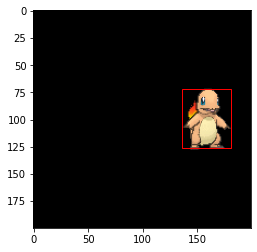

In [26]:
pokemon_prediction_flip()

### **Object Localizatin of Charmander on colored background**

In [15]:
# download and unzip the backgrounds
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

!unzip -n backgrounds.zip

--2023-02-12 15:01:38--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  1.30MB/s    in 0.4s    

2023-02-12 15:01:38 (1.30 MB/s) - ‘backgrounds.zip’ saved [494000/494000]

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflati

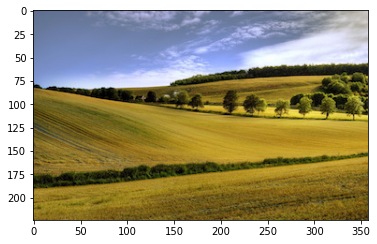

In [17]:
background_files = glob("backgrounds/*.jpg")   # returns file path that match this pattern

# n.b: used list for the backgrounds array, since np array needs all elements to be of same size
# for proper use, so I just used list since not all elements are same size
backgrounds = [np.array(image.load_img(f)) for f in background_files]

plt.imshow(backgrounds[10])

In [18]:
def pokemon_generator_bg(batch_size = 64):
  while True:
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w = bg.shape[:2]

        # to make backgrounds of diff sizes to bE POKE_DIM i.e 200
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

         # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random()
        new_height = int(CH_H * scale)
        new_width = int(CH_W * scale)
        obj = resize(
            ch,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8) # keep it from 0..255
        
        # maybe flip
        if np.random.random() < 0.5:
          obj = np.fliplr(obj)

        # choose a random location to store the object
        row0 = np.random.randint(POKE_DIM - new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width


        # can't 'just' assign obj to a slice of X
        # since the transparent parts will be black (0)
        # to properly place charmanda obj on the background image
        mask = (obj[:,:,3] == 0)   # find where pokemon image is transparent in alpha channel i.e the background pixels and ret 1 else 0
        bg_slice = X[i, row0:row1, col0:col1, :]  # slice where we want to place the object

        # (h,w,1) x (h,w,3)
        # also makes pixels in bg_slice where charmander image background is to be transaparent
        # and areas where it isn't(where charmander is) to be dark i.e 0
        bg_slice = np.expand_dims(mask, -1) * bg_slice

        # if i == 0:
        #   plt.imshow(bg_slice * 255.)
        
        bg_slice += obj[:,:, :3]  # adds the pokemon obj to the slice
        X[i, row0:row1, col0:col1, :] = bg_slice  # puts the slice back in background image


        # make targets
        Y[i,0] = row0/POKE_DIM
        Y[i,1] = col0/POKE_DIM
        
        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM
      
      yield X / 255., Y

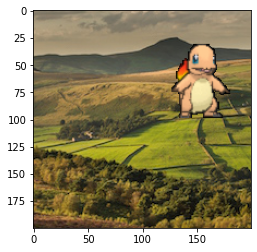

In [19]:
# test if function works as expected

xx = None
yy = None

for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

plt.imshow(xx[5])

In [30]:
model = make_model2()

model.fit(
    pokemon_generator_bg(),
    steps_per_epoch = 50,
    epochs = 10
)

Epoch 1/10
50/50 [==============================] - 14s 261ms/step - loss: 0.6065
Epoch 2/10
50/50 [==============================] - 13s 264ms/step - loss: 0.5689
Epoch 3/10
50/50 [==============================] - 13s 264ms/step - loss: 0.5611
Epoch 4/10
50/50 [==============================] - 13s 264ms/step - loss: 0.5568
Epoch 5/10
50/50 [==============================] - 13s 268ms/step - loss: 0.5538
Epoch 6/10
50/50 [==============================] - 14s 271ms/step - loss: 0.5531
Epoch 7/10
50/50 [==============================] - 13s 264ms/step - loss: 0.5524
Epoch 8/10
50/50 [==============================] - 14s 273ms/step - loss: 0.5501
Epoch 9/10
50/50 [==============================] - 14s 275ms/step - loss: 0.5490
Epoch 10/10
50/50 [==============================] - 13s 265ms/step - loss: 0.5478


In [31]:
# Make predictions
def pokemon_prediction_bg():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w = bg.shape[:2]
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
  # resize charmander - make it bigger or smaller
  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8) # keep it from 0..255
        
  # maybe flip
  if np.random.random() < 0.5:
    obj = np.fliplr(obj)
        
  # choose a random location to store the object
  row0 = np.random.randint(POKE_DIM - new_height)
  col0 = np.random.randint(POKE_DIM - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width
        
  # can't 'just' assign obj to a slice of X
  # since the transparent parts will be black (0)
  mask = (obj[:,:,3] == 0) # find where the pokemon is 0
  bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
  bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
  bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
  x[row0:row1,col0:col1,:] = bg_slice # put the slice back
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Draw the box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 107 19 183 78
1/1 [==============================] - 0s 34ms/step
pred: 111 23 183 80


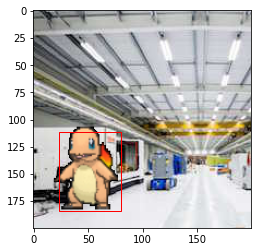

In [40]:
pokemon_prediction_bg()